# Causal Inference

In this project, I will be analyzing the causal inference for data science jobs. 

The dataset is from aijobs.net (https://www.kaggle.com/datasets/arnabchaki/data-science-salaries-2023/data)


## Dictionary
- work_year: The year the salary was paid
- experience_level: The experience level in the job during the year
- employment_type: The type of employment for the role
- job_title: The name of the role
- salary: The total gross salary amount paid
- salary_currency: The currency of the salary paid as an ISO 4217 currency code
- salaryinusd: The salary in USD
- employee_residence: Employee's primary country of residence in during the work year as an ISO 3166 country code
- remote_ratio: The overall amount of work done remotely
- company_location: The country where the employer company is from
- company_size: The median number of people that worked for the company during the year

New features:
- residence_location_match: Whether the residence and the company location are the same
- job_title_words: job title's word count 
- Engineer: Binary value for whether the job title includes "Engineer"
- Analyst: Binary value for whether the job title includes "Analyst"
- Scientist: Binary value for whether the job title includes "Scientist"
- Machine Learning: Binary value for whether the job title includes "Machine Learning"
- Architect: Binary value for whether the job title includes "Architect"
- Manager: Binary value for whether the job title includes "Manager"
- Research: Binary value for whether the job title includes "Research"
- Other: Binary value for job titles that do not have any of the keywords above


In this notebook, I would like to explore the following questions:
* If a person's title does not contain scientist would their salary be lower?
* How does the job title impact salary?
* If a person's work location is not US, how would their salary be affected?
* Is salary caused by an employee's company size?
* How does each factor play a role in determining salary level?
* Which factors contribute positively to the prediction?

## Setup

In [502]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import pandas as pd
import seaborn as sns

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)
    
# Ignore warnings
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

# Preprocessing
from sklearn.preprocessing import OrdinalEncoder 

# Causal ml 
import causalml
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

from causalml.inference.meta import LRSRegressor
from causalml.inference.meta import XGBTRegressor, MLPTRegressor
from causalml.inference.meta import BaseXRegressor, BaseRRegressor, BaseSRegressor, BaseTRegressor
from causalml.match import NearestNeighborMatch, MatchOptimizer, create_table_one
from causalml.propensity import ElasticNetPropensityModel
from causalml.dataset import *
from causalml.metrics import *

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.tree import DecisionTreeRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from causalml.inference.tf import DragonNet
import importlib
print(importlib.metadata.version('causalml') )

from causalml.inference.tree import UpliftTreeClassifier

%matplotlib inline

# cross validation
from sklearn.model_selection import cross_val_score, KFold
from xgboost import XGBRegressor


0.14.1


## Import Data

In [503]:
salaries = pd.read_csv('/Users/chiaralu/Desktop/Courses/INSY_695_078/ds_salaries.csv')

In [504]:
salaries.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3755 entries, 0 to 3754
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           3755 non-null   int64 
 1   experience_level    3755 non-null   object
 2   employment_type     3755 non-null   object
 3   job_title           3755 non-null   object
 4   salary              3755 non-null   int64 
 5   salary_currency     3755 non-null   object
 6   salary_in_usd       3755 non-null   int64 
 7   employee_residence  3755 non-null   object
 8   remote_ratio        3755 non-null   int64 
 9   company_location    3755 non-null   object
 10  company_size        3755 non-null   object
dtypes: int64(4), object(7)
memory usage: 322.8+ KB


The dataset has 11 columns and 3,754 rows. There are no null values for any of the columns.

## Preprocessing

In [505]:
# Drop columns
salaries = salaries.drop(columns=['salary', 'salary_currency'], axis=1)


Salary and currency columns are dropped because salary is captured in salary_in_usd. Having all salaries in one currency helps in the comaprison. 

In [506]:
# New features
# create binary attribute to see if employee residence matches company location; 1 if yes, 0 if no
salaries['residence_location_match'] = np.where(salaries['employee_residence'] == salaries['company_location'], 1, 0)
#create variable to capture length of job title (number of words)
salaries['job_title_words'] = salaries['job_title'].str.split().str.len()  

New features are created. Having a binary attribute comparing whether an employee lives and works in the same country captures information on the proximity of their workplace. This column has a relation to remote ratio, because if an employee is in another country than they are very likely to be working remotely. However, this assumption will be tested later in teh correlation matrix. 

The title is valuable, as more complex titles may imply higher specialization and more complexity. This is an attempt to grasp the relationship between job complexity and salary level.




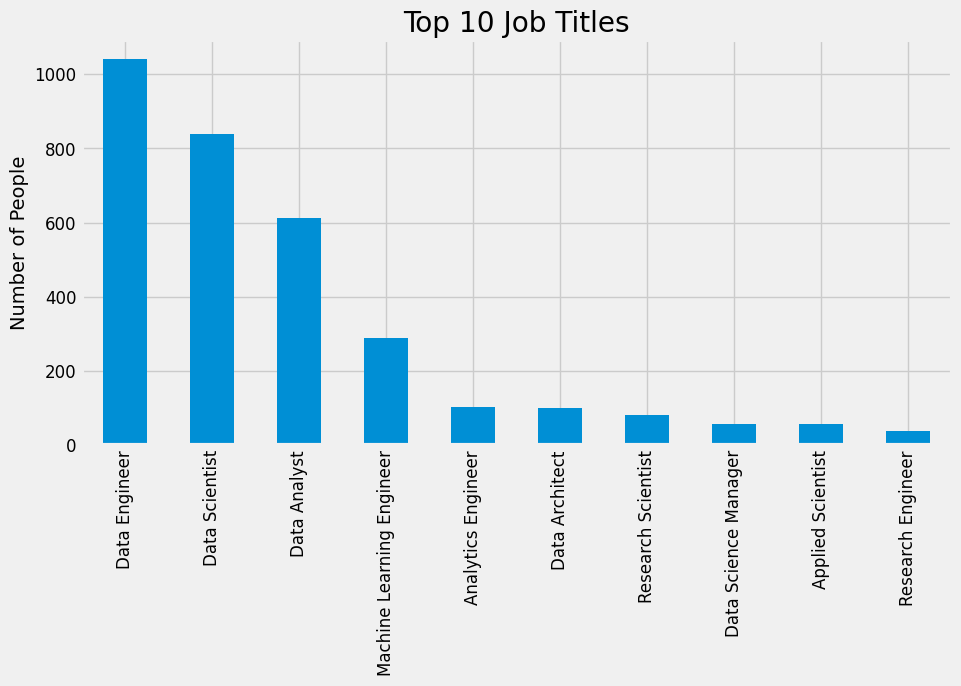

In [507]:
# View top 10 jobs to find which keywords to use for job title
salaries["job_title"].value_counts()

salaries["job_title"].value_counts().nlargest(10).plot(kind='bar', figsize=(10,5))
plt.title("Top 10 Job Titles")
plt.ylabel('Number of People')
plt.show()

In [508]:
# Use the top 10 job titles to create binary bins- 1 if 'job_title' contains the keyword, 0 if not
keywords = ['Engineer', 'Analyst', 'Scientist', 'Machine Learning', 'Architect', 'Manager', 'Research']
for key in keywords:
    salaries[str(key)] = salaries['job_title'].str.contains(str(key)).astype(int)
# categorize those without any of the keywords as 'Other'
salaries['Other'] = np.where(salaries['job_title'].str.contains('Engineer|Analyst|Scientist|Machine Learning|Architect|Manager|Research') == False, 1, 0)

# now drop the original job_title column
salaries = salaries.drop(columns=['job_title'], axis=1)


To group jobs, I took the key words approach. If a job_title includes any of the keywords listed, a binary value will be assigned. Jobs that do not have any of the keywords will get 1 in the "Other" column.

In [509]:
# We divide values in "Other" to see how much information we lost by binning the job titles
salaries['Other'].value_counts()/salaries.shape[0] 


0    0.965646
1    0.034354
Name: Other, dtype: float64

Checking how many values are classified as "Others" is important to understand data leakage. 3.4% of total observations were other than the keywords defined above, but it is an acceptable cut.

In [510]:
salaries.head()

,work_year,experience_level,employment_type,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,residence_location_match,job_title_words,Engineer,Analyst,Scientist,Machine Learning,Architect,Manager,Research,Other
0,2023,SE,FT,85847,ES,100,ES,L,1,3,0,0,1,0,0,0,0,0
1,2023,MI,CT,30000,US,100,US,S,1,2,1,0,0,0,0,0,0,0
2,2023,MI,CT,25500,US,100,US,S,1,2,1,0,0,0,0,0,0,0
3,2023,SE,FT,175000,CA,100,CA,M,1,2,0,0,1,0,0,0,0,0
4,2023,SE,FT,120000,CA,100,CA,M,1,2,0,0,1,0,0,0,0,0


In [511]:
# Encoding
cat_attr_ordinal = ["experience_level", "company_size"]
# Give mapping dictionary
experience_order = ['EN', 'MI', 'SE', 'EX']
company_size_order = ['S', 'M', 'L']
# Create an instance of OrdinalEncoder with specified category orders
ordinal_encoder = OrdinalEncoder(categories=[experience_order, company_size_order])
salaries[cat_attr_ordinal] = ordinal_encoder.fit_transform(salaries[cat_attr_ordinal])
# Specify data type for these columns
salaries['experience_level'] = salaries['experience_level'].astype(int)
salaries['company_size'] = salaries['company_size'].astype(int)
# Create label encoding for employment type, as there are fewer than 10 unique values
salaries['employment_type'] = salaries['employment_type'].astype('category').cat.codes
# Create frequency encoding for employee_residence and company_location. Get frequency of each category and map to the column
residence_freq = salaries['employee_residence'].value_counts()
location_freq = salaries['company_location'].value_counts()
salaries['employee_residence'] = salaries['employee_residence'].map(residence_freq)
salaries['company_location'] = salaries['company_location'].map(location_freq)

salaries.head()


,work_year,experience_level,employment_type,salary_in_usd,employee_residence,remote_ratio,company_location,company_size,residence_location_match,job_title_words,Engineer,Analyst,Scientist,Machine Learning,Architect,Manager,Research,Other
0,2023,2,2,85847,80,100,77,2,1,3,0,0,1,0,0,0,0,0
1,2023,1,0,30000,3004,100,3040,0,1,2,1,0,0,0,0,0,0,0
2,2023,1,0,25500,3004,100,3040,0,1,2,1,0,0,0,0,0,0,0
3,2023,2,2,175000,85,100,87,1,1,2,0,0,1,0,0,0,0,0
4,2023,2,2,120000,85,100,87,1,1,2,0,0,1,0,0,0,0,0


Ordinal encoding is applied to features with a sequential relationship. For exmaple experienced employees should get a higher value than entry level employees, and large companies should get a larger value than small companies to reflect the company size.

Employment types have no direct relationship with each other, therefore label encoding is used. One-hot-encoding would increase dimensionality, thus label encoding works better.

For features that capture countries, frequency encoding is used. This helps capturing information on the number of people working in a country; this may cause bias, as over 3000 observations work from the US.

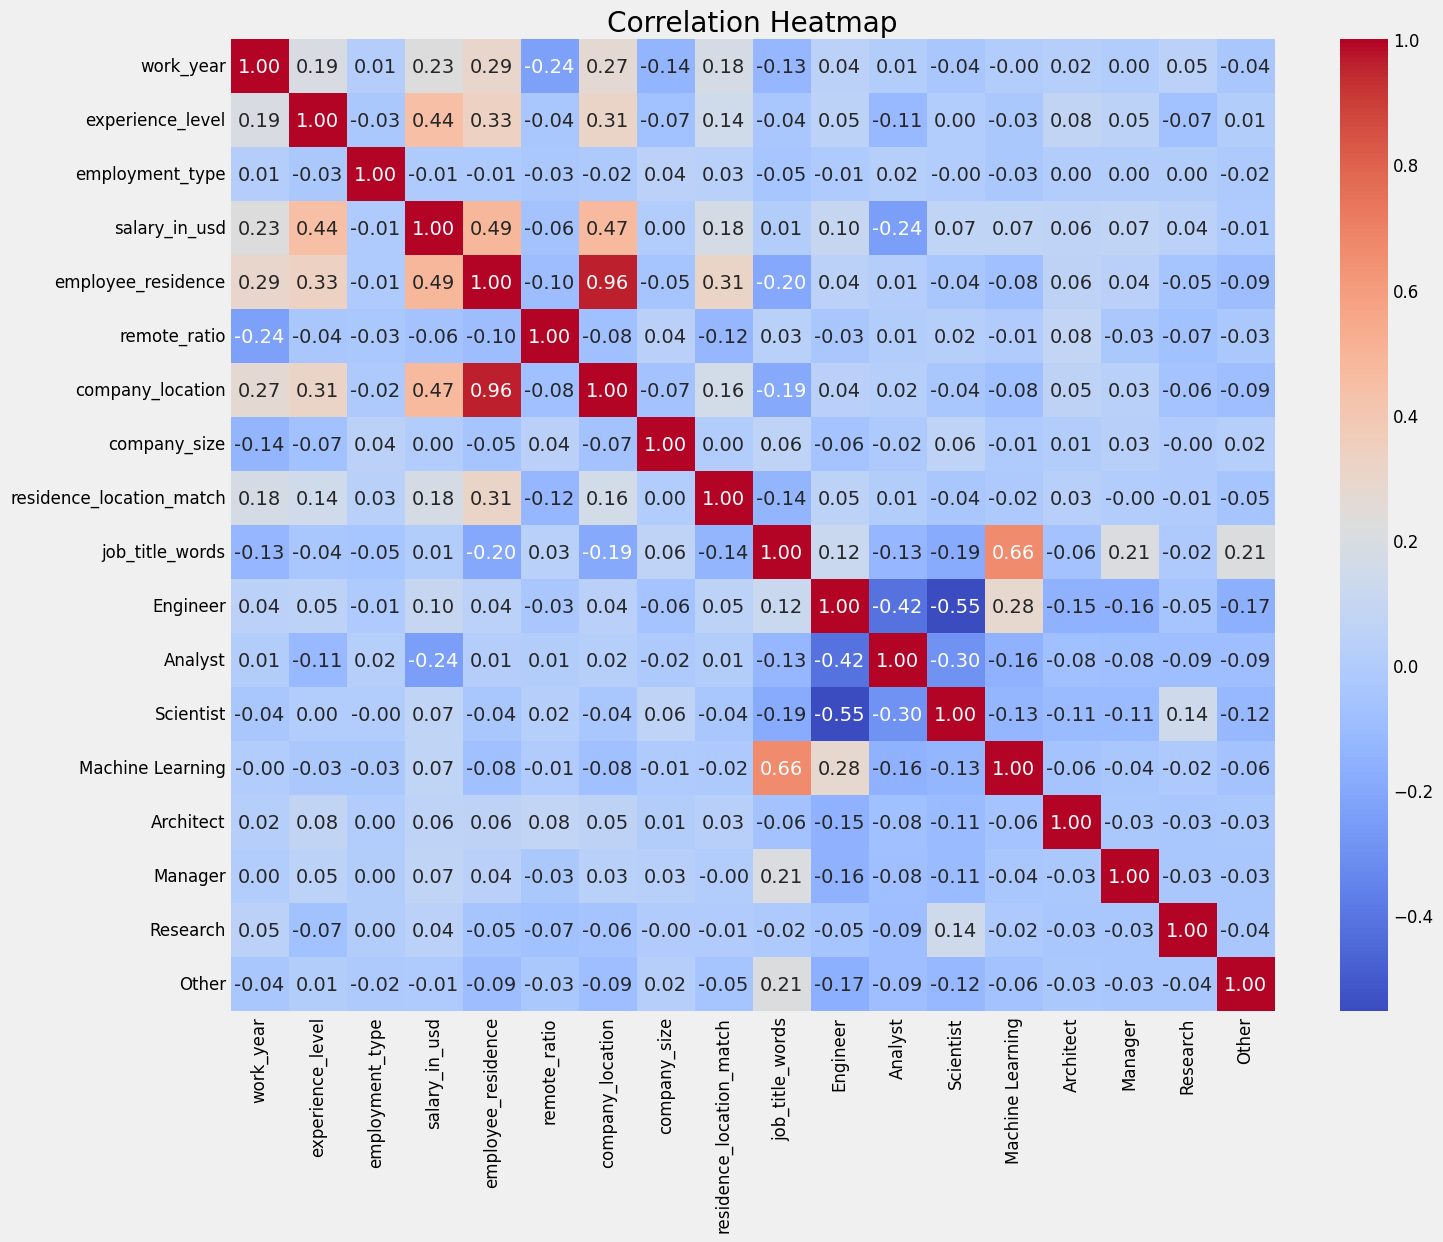

In [512]:
# check for multicollinearity
corr_matrix = salaries.corr()

# Plot the correlation matrix using a heatmap
plt.figure(figsize=(15, 12))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()


From the correlation matrix, it can be observed that there is no multicollinearity. There are highly correlated variables like Machine Learning and jot_title_words. This makes sense, because ML job titles tend to be longer. Moreover, if an employee is an engineer, they are likley no going to be scientists or analysts at the same time. The correlations between the new variables created to bin job titles are mostly negative, indicating that the binning was effective in defining the distinctive jobs.

Positive correlations that can be observed are experience with salary and company location with salary. 

In [539]:
# Define X and y for entire dataset 
X = salaries.drop(columns = ["salary_in_usd"], axis=1)
y = salaries["salary_in_usd"]

In [514]:
# Try causal inference using Scaled X and y
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_std = scaler.fit_transform(X)
y_std = scaler.fit_transform(y.values.reshape(-1,1)).flatten()

I tried running causal inference with scaled data, however the outputs were in the trillions, so I chose to use non-standardized x and y.

## Train Test Split

In [540]:
# train test split on X and y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [517]:
# Check number of observations in train set
3755*0.8

3004.0

Since there is no hyperparameter tuning involved, I did not create a validation set. I will test the RMSE on the test sets.

## Learner S - LRSRegressor

In [533]:
treatment = salaries['Engineer'].iloc[X_train.index] == 1

learner_s = LRSRegressor()
te, lb, ub = learner_s.estimate_ate(X_train, treatment, y_train)

def print_ate(te, lb, ub):
    print('ATE estimate: ${:.02f}'.format(te[0]))
    print('ATE lower bound: ${:.02f}'.format(lb[0]))
    print('ATE upper bound: ${:.02f}'.format(ub[0]))

print_ate(te, lb, ub)

ATE estimate: $17759.28
ATE lower bound: $45.80
ATE upper bound: $35472.77


This outcome means that those who are engineers tend to get on average $17,759.28 more in salary than those who do not have "Engineer" in their job title. 

## XGBTRegressor

In [541]:
xg = XGBTRegressor(random_state=42)
te, lb, ub = xg.estimate_ate(X_train, treatment, y_train)
print("ATE Using XGBTRegressor")
print_ate(te, lb, ub)

ATE Using XGBTRegressor
ATE estimate: $1505.55
ATE lower bound: $-1697.69
ATE upper bound: $4708.80


In [519]:
treatment = salaries['residence_location_match'].iloc[X_train.index] == 1

te, lb, ub = learner_s.estimate_ate(X_train, treatment, y_train)
print_ate(te, lb, ub)

ATE estimate: $8930.45
ATE lower bound: $3380.49
ATE upper bound: $14480.42


This output means that employees who work and live in the same country tend to get $8,930.45 higher salary on average than those who have different company location and residence country. This is reasonable, as those who have different residence location and company location may be impacted by foreign exchange when reeiving their salary or the companies cover for their high traveling expenses, leading to lower salary overall.

Based on S-learner Regressor, having data "Manager" in job title increases salary the most. Having "Manager" in the job title can increase salary by $22,123.77 on average, with confidence interval $3,785 and $40,462.55. Compared to other words, having analyst in the job title increases the salary by the lowest number.

In [520]:
# testing on treatment group having company location < 100
treatment = (salaries['company_location'].iloc[X_train.index] < 100)
#treatment = (salaries['company_location'].iloc[X_train.index] < 173)
#treatment = (salaries['company_location'].iloc[X_train.index] > 3000)


learner_s = LRSRegressor()
te, lb, ub = learner_s.estimate_ate(X_train, treatment, y_train)
print_ate(te, lb, ub)

ATE estimate: $-14486.61
ATE lower bound: $-24218.18
ATE upper bound: $-4755.05


For employees who work at companies located in underepresented countries, their average salary tends to be $14,486.61 lower than the control group, with lower bound negative $24,218.18 and upper bound $4,755.05 lower compared to the control group (employees whose company location is greater than 100). It would be interesting to see what is the threshold before the ATE estimate turns positive/negative. Being in a large country (like the US) can mean higher competition, thus lower salary. However, being in a country that is too small (that has fewer observations), is also not beneficial for having business opportunities. When setting company location to less than 173, the ATE estimate is $35,2552.14. This shows that being in a mediocre country can actually increase salary. 

Noteworthy, for a more statistically significant result, the dataset would need to have more observations from other countries than the US and from less represented job titles.

## Learner T

In [521]:
# Setting the treatment group as scientist
treatment = salaries['Scientist'].iloc[X_train.index] ==1 

# Calling the Base Learner class and feeding in XGB
learner_tXGB = BaseTRegressor(learner=XGBRegressor())
te, lb, ub = learner_tXGB.estimate_ate(X_train, treatment, y_train)
print('\nATE Using the BaseTRegressor class and using XGB:')
print_ate(te, lb, ub)

# Calling the Base Learner class and feeding in LinearRegression
learner_tLR = BaseTRegressor(learner=LinearRegression())
te, lb, ub = learner_tLR.estimate_ate(X_train, treatment, y_train)
print('\nATE Using the BaseTRegressor class and using Linear Regression:')
print_ate(te, lb, ub)


ATE Using the BaseTRegressor class and using XGB:
ATE estimate: $12016.48
ATE lower bound: $8584.51
ATE upper bound: $15448.45

ATE Using the BaseTRegressor class and using Linear Regression:
ATE estimate: $21911.86
ATE lower bound: $17849.05
ATE upper bound: $25974.68


## Learner X

In [522]:
treatment = salaries['Scientist'].iloc[X_train.index] ==1 

# Calling the Base Learner class and feeding in XGB
learner_xXGB = BaseXRegressor(learner=XGBRegressor())
te, lb, ub = learner_xXGB.estimate_ate(X_train, treatment, y_train)
print('\nATE Using the BaseXRegressor class and using XGBoosting:')
print_ate(te, lb, ub)

# Try Base X with Linear Regression
learner_xLR = BaseXRegressor(learner=LinearRegression())
te, lb, ub = learner_xLR.estimate_ate(X_train, treatment, y_train)
print('\nATE Using the BaseXRegressor class and using Linear Regression:')
print_ate(te, lb, ub)


ATE Using the BaseXRegressor class and using XGBoosting:
ATE estimate: $9699.79
ATE lower bound: $6344.44
ATE upper bound: $13055.13

ATE Using the BaseXRegressor class and using Linear Regression:
ATE estimate: $37126.80
ATE lower bound: $33100.88
ATE upper bound: $41152.73


## Learner R

In [523]:
treatment = salaries['Scientist'].iloc[X_train.index] ==1 
# Calling the Base Learner class and feeding in XGB
learner_rXGB = BaseRRegressor(learner=XGBRegressor())
te, lb, ub = learner_rXGB.estimate_ate(X_train, treatment, y_train)
print('\nATE Using the BaseRRegressor class and using XGBoosting:')
print_ate(te, lb, ub)


# Try Base R with Linear Regression
learner_rLR = BaseRRegressor(learner=LinearRegression())
te, lb, ub = learner_rLR.estimate_ate(X_train, treatment, y_train)
print('\nATE Using the BaseRRegressor class and using Linear Regression:')
print_ate(te, lb, ub)


ATE Using the BaseRRegressor class and using XGBoosting:
ATE estimate: $2935.96
ATE lower bound: $2855.39
ATE upper bound: $3016.53

ATE Using the BaseRRegressor class and using Linear Regression:
ATE estimate: $4153.45
ATE lower bound: $4078.67
ATE upper bound: $4228.23


## Neural Network ATE

In [524]:
nn = MLPTRegressor(hidden_layer_sizes=(10, 10), 
                   learning_rate_init = .1,
                   early_stopping = True,
                   random_state = 42)

print('ATE Using Nueral Network MLP:')
te, lb, ub = nn.estimate_ate(X_train, treatment, y_train)
print_ate(te, lb, ub)

ATE Using Nueral Network MLP:
ATE estimate: $13750.13
ATE lower bound: $9421.97
ATE upper bound: $18078.29


In [537]:
# Validate above models using RMSE 
val_results = []

# List of learners
learners = [learner_s, xg, learner_tXGB, learner_tLR, learner_xXGB, learner_xLR, learner_rXGB, learner_rLR, nn]

# Convert the learner objects to their string representations
learner_names = ['learner_s', 'XGBT','learner_tXGB', 'learner_tLR', 'learner_xXGB', 'learner_xLR', 'learner_rXGB', 'learner_rLR', 'neural network']

# Iterate over each learner and its corresponding name
for learner, learner_name in zip(learners, learner_names):
    # Predict on test set
    p = learner.predict(X_test).squeeze()
    # Calculate RMSE
    rmse = causalml.metrics.rmse(y_test, p)
    # Append results to the list
    val_results.append({"Learner": learner_name, "RMSE": rmse})
    
results_df = pd.DataFrame(val_results)
# Sort the DataFrame by RMSE in descending order
results_df = results_df.sort_values(by="RMSE", ascending=True)

results_df


,Learner,RMSE
5,learner_xLR,113100.884382
3,learner_tLR,131733.424268
0,learner_s,133569.540925
8,neural network,138101.314016
2,learner_tXGB,143881.304243
4,learner_xXGB,143967.720643
7,learner_rLR,145732.776445
6,learner_rXGB,151556.820280
1,XGBT,153745.993938


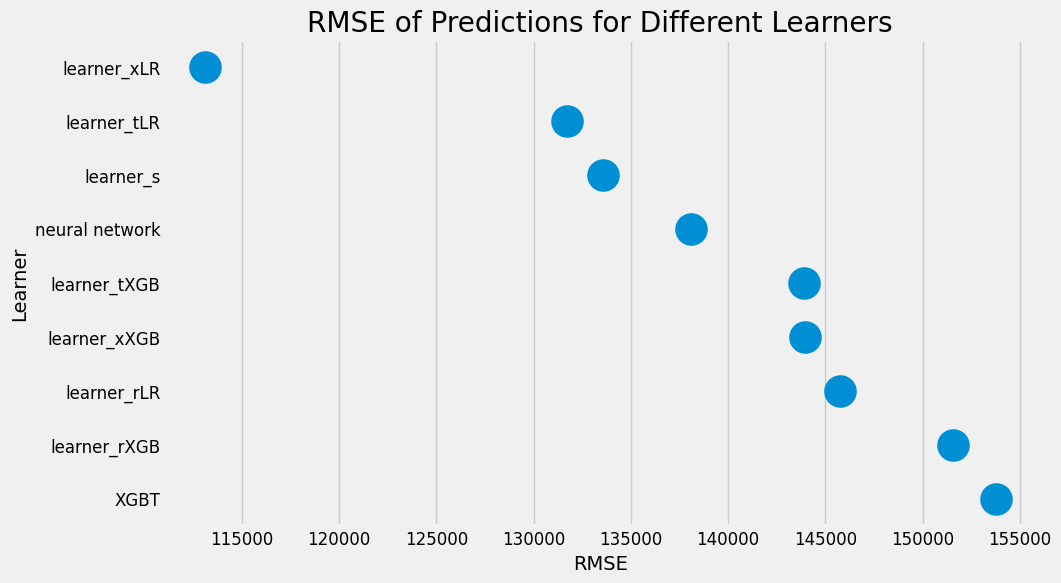

In [538]:
# Visualize the RMSE of each learner
plt.figure(figsize=(10, 6))
sns.pointplot(x="RMSE", y="Learner", data=results_df, join=False)
plt.xlabel('RMSE')
plt.ylabel('Learner')
plt.title('RMSE of Predictions for Different Learners')
plt.show()

Based on the validation results, Learner X utilizing linear regression demonstrates superior performance in predicting causality for "Scientist" job roles. It's noteworthy that different treatments may have different learners that predict more accurately for them.

In [526]:
# Use best learner to predict on all job titles
keywords = ['Engineer', 'Analyst', 'Scientist', 'Machine Learning', 'Architect', 'Manager', 'Research']

results_df = pd.DataFrame(columns=keywords)

for i in keywords:
    treatment = salaries[i].iloc[X_train.index] == 1
    learner_xLR = BaseXRegressor(learner=LinearRegression())
    te, lb, ub = learner_xLR.estimate_ate(X_train, treatment, y_train)
    
    # Append the results as a new column in the DataFrame
    results_df[i] = [te[0], lb[0], ub[0]]

# Add index labels for each row
results_df.index = ['ATE estimate', 'ATE lower bound', 'ATE upper bound']

results_df


did not converge


,Engineer,Analyst,Scientist,Machine Learning,Architect,Manager,Research
ATE estimate,31903.073884,-2405.678811,37126.803421,26844.539992,259028.096922,12698.744523,13594.284729
ATE lower bound,28351.484119,-6306.465096,33100.877388,20537.070223,170681.913025,3621.508489,2175.161826
ATE upper bound,35454.663648,1495.107474,41152.729454,33152.009761,347374.280819,21775.980557,25013.407631


Text(0.5, 0, 'ATE Estimate for Each Keyword')

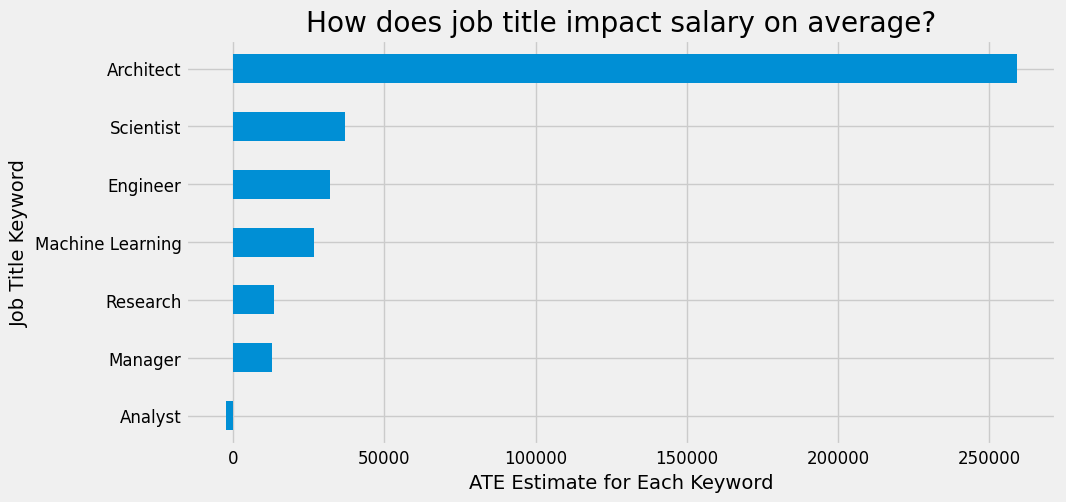

In [527]:
# Rank the results based on ATE estimate
results_df.loc['ATE estimate'].sort_values(ascending=True).plot(kind='barh', figsize=(10, 5))

plt.title('How does job title impact salary on average?')
plt.ylabel('Job Title Keyword')
plt.xlabel('ATE Estimate for Each Keyword')

# plot frequency of each job in training set


 Being an architect, a scientist, or an engineer will cause salaries to be higher on average. Having "Analyst" in the job title will cause salary to be lower by $2.4k on average. 
 
 When an observation has "Architect" in their job title, this causes their salary to be $259k higher on average. This result is surprising and overly optimistic due to the bias in the original dataset. The original dataset had 105 architects. The training set was able to pick up 89 of them, however this is still very small compared to other job titles.

In [528]:
print(salaries['Architect'].value_counts())
X_train['Architect'].value_counts()


0    3650
1     105
Name: Architect, dtype: int64


0    2915
1      89
Name: Architect, dtype: int64

In [529]:
# Test for company size
sizes = [0, 1, 2]

results_df = pd.DataFrame()

for s in sizes:
    treatment = salaries['company_size'].iloc[X_train.index] == s
    learner_xLR = BaseXRegressor(learner=LinearRegression())
    te, lb, ub = learner_xLR.estimate_ate(X_train, treatment, y_train)
    
    # Append the results as new columns in the DataFrame
    results_df[f'company_size_{s}'] = [te[0], lb[0], ub[0]]

results_df.index = ['ATE estimate', 'ATE lower bound', 'ATE upper bound']

results_df

,company_size_0,company_size_1,company_size_2
ATE estimate,-20430.109495,1746.886760,-2658.494888
ATE lower bound,-29286.840276,-3432.194056,-8544.123551
ATE upper bound,-11573.378713,6925.967576,3227.133775


People in a mid-size company can earn $1,746.88 higher salary than those who work in small or large comapnies.

# Feature Interpretation

In [530]:
# Interpreting Causal ML using feature importance
treatment = salaries['Scientist'].iloc[X_train.index] == 1

learner_xLR.estimate_ate(X_train, treatment, y_train)
learner_xLR_tau = learner_xLR.fit_predict(X_train, treatment, y_train)

model_tau_feature = RandomForestRegressor()

learner_xLR.get_importance(X = X_train,
                           tau = learner_xLR_tau,
                           model_tau_feature = model_tau_feature,
                           normalize=True, 
                           method='auto', 
                           features = X_train.columns)


{True: job_title_words             0.316395
 employee_residence          0.227278
 Machine Learning            0.199165
 Research                    0.048424
 employment_type             0.036879
 Engineer                    0.028351
 residence_location_match    0.028312
 work_year                   0.025006
 company_location            0.016326
 remote_ratio                0.016222
 experience_level            0.015086
 Architect                   0.010991
 Manager                     0.007595
 Analyst                     0.007472
 Scientist                   0.006736
 Other                       0.006556
 company_size                0.003206
 dtype: float64}

Text(0.5, 1.0, 'Auto Feature Importance (Test set)')

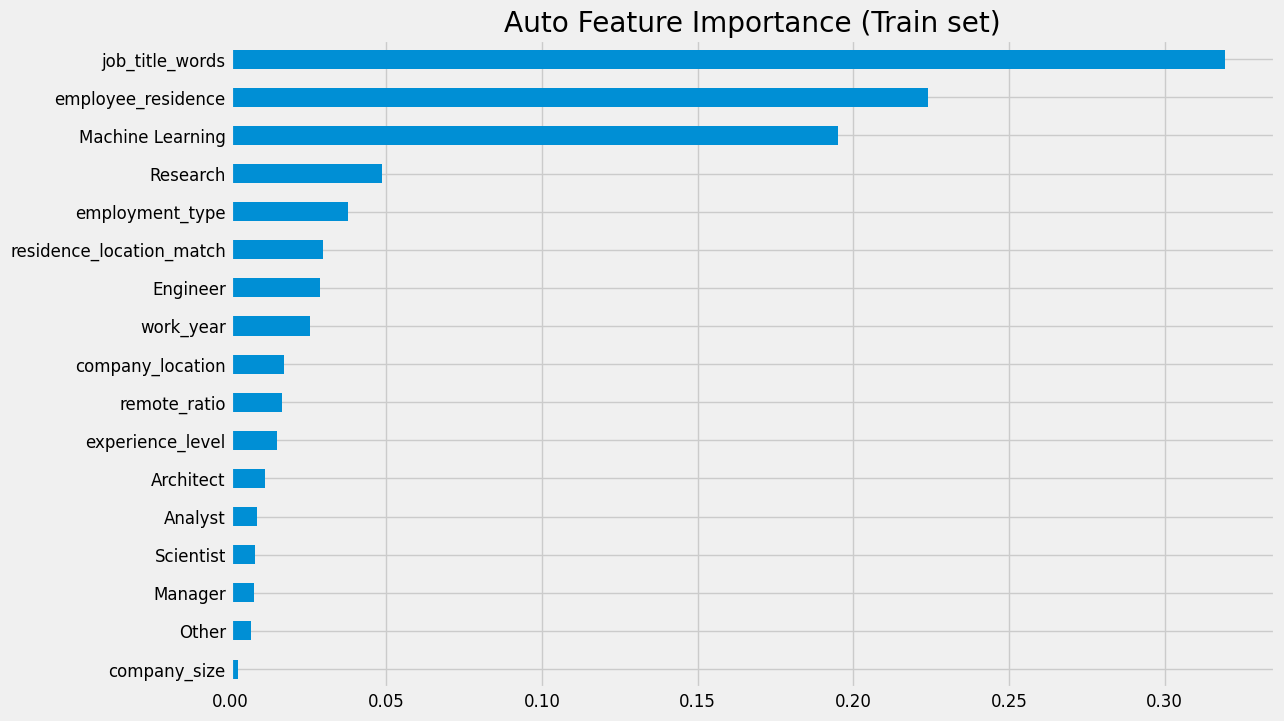

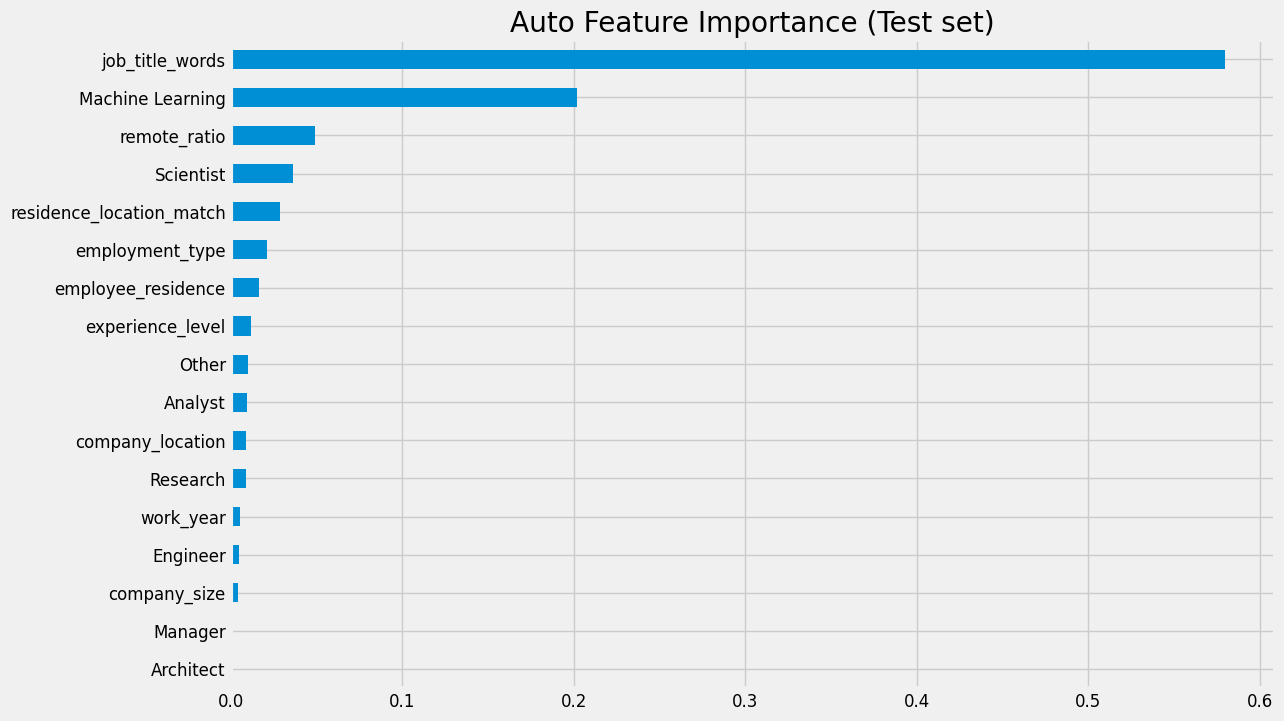

In [531]:
# plot feature importance
learner_xLR.plot_importance(X = X_train,
                           tau = learner_xLR_tau,
                           model_tau_feature = model_tau_feature,
                           normalize=True, 
                           method='auto', 
                           features = X_train.columns)
plt.title('Auto Feature Importance (Train set)')


# View if test set has similar importance as training set
treatment_test = salaries['Scientist'].iloc[X_test.index] == 1
test_learner_xLR_tau = learner_xLR.fit_predict(X_test, treatment_test, y_test)

learner_xLR.plot_importance(X = X_test,
                           tau = test_learner_xLR_tau,
                           model_tau_feature = model_tau_feature,
                           normalize=True, 
                           method='auto', 
                           features = X_test.columns)
plt.title('Auto Feature Importance (Test set)')

On both the train and test sets, the number of words in the job title plays teh most important contribution to the final prediction. Machine Learning is in the top 3 for both. Assuming that the longer the job title, the more complex or specialized the employee is, this shows that the complexity of the work is a strong contributor in predicting causality of salary.

Based on this feature importance, the company size and whether the employee has certain keywords in their job title (other than Machine Learning) have low importance in prediction.  

Text(0.5, 1.0, 'Permutation Feature Importance (Test set)')

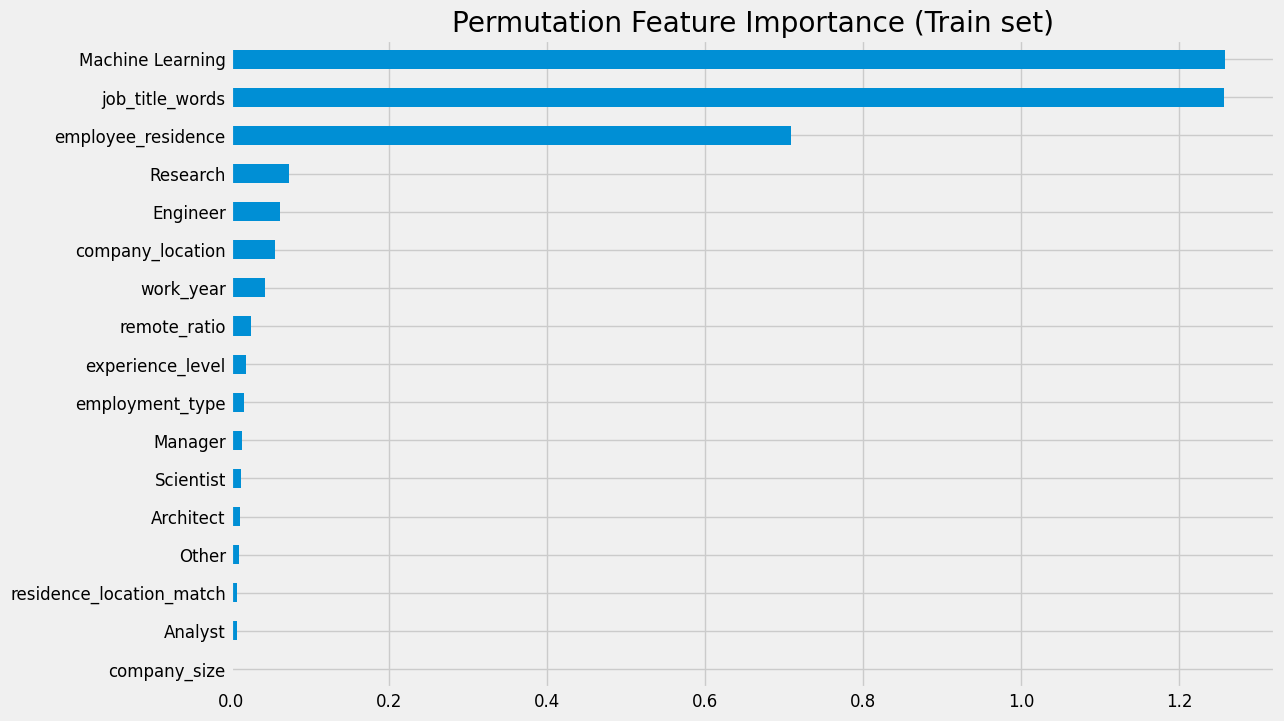

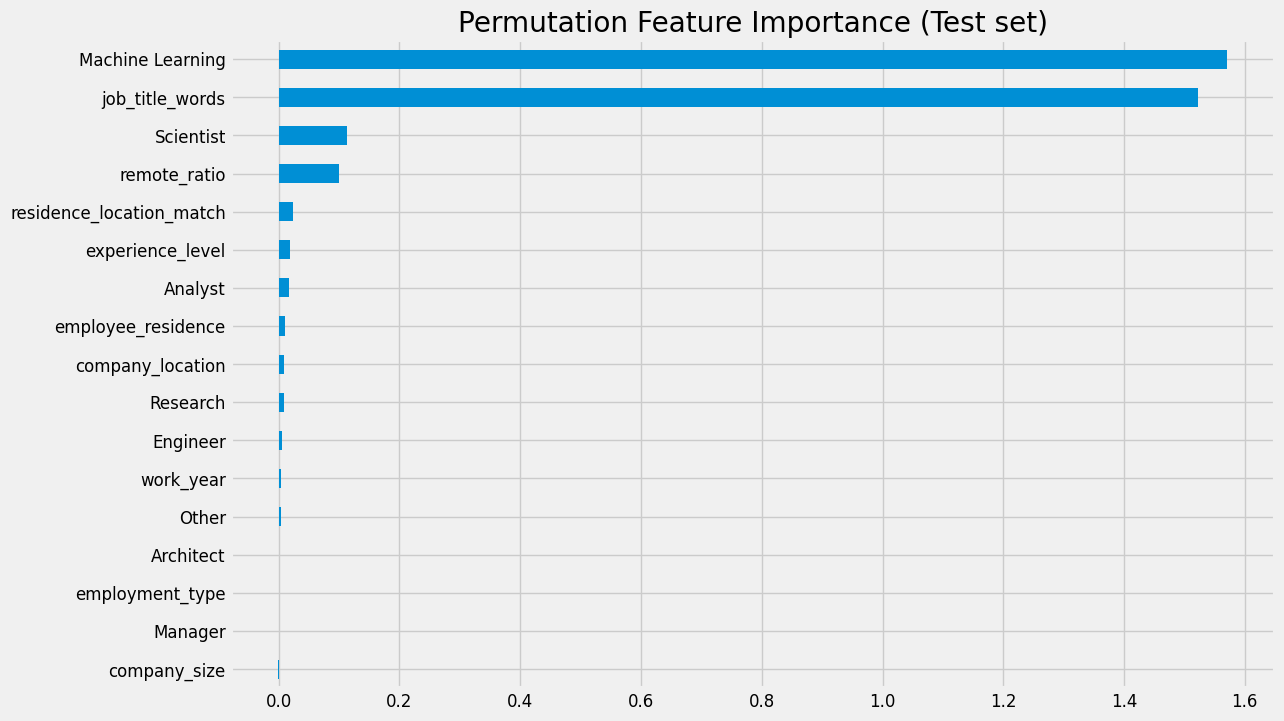

In [501]:
# plot feature importance 
learner_xLR.plot_importance(X = X_train,
                           tau = learner_xLR_tau,
                           model_tau_feature = model_tau_feature,
                           normalize=True, 
                           method='permutation', 
                           features = X_train.columns)
plt.title('Permutation Feature Importance (Train set)')

# plot for test set
learner_xLR.plot_importance(X = X_test,
                           tau = test_learner_xLR_tau,
                           model_tau_feature = model_tau_feature,
                           normalize=True, 
                           method='permutation', 
                           features = X_test.columns)
plt.title('Permutation Feature Importance (Test set)')

Results are similar using `auto` and `permutation`. The difference between the tow is that `auto` calculates importance based on estimator’s default implementation of feature importance and `permutation` calculates importance based on mean decrease in accuracy when a feature column is permuted.

## Shapley Values

In [363]:
# Get SHAP values
shap_xlearner = learner_xLR.get_shap_values(X=X_train, tau=learner_xLR_tau)
shap_xlearner


[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

{True: array([[-1005.46248793, -1023.02174636,     0.        , ...,
            71.17591798,  -542.02620802,    72.62292625],
        [ 1466.9105503 ,  1486.04441274,     0.        , ...,
           115.78129029, 11632.44504434,    76.05396495],
        [-1180.69963046,  -609.42048139,     0.        , ...,
           114.33208369,  -509.32866066,    64.76653066],
        ...,
        [ 1763.03296428, -2661.48598453,     0.        , ...,
           118.34402765,  -557.67366517,    63.33266048],
        [-2704.75651838,   545.23157259,     0.        , ...,
            66.40310611, 11154.58428416,    92.12574468],
        [ -749.24537446,   936.37780481,     0.        , ...,
           178.31833548,  -348.90841032,   120.58581346]])}

SHAP values are used to explain which factors contribute to the model's workings.

In [374]:
# Access SHAP values for the treatment group where 'Scientist' is True
shap_values_scientist = shap_xlearner[True]

# Access SHAP values for the 'Scientist' feature
scientist_shap_values = shap_values_scientist[:, X_train.columns.get_loc('Scientist')]

# Calculate mean absolute SHAP values for the 'Scientist' feature
mean_shap_values_scientist = np.mean(np.abs(scientist_shap_values), axis=0)
print(f"The marginal contribution of having 'Scientist' in one's job title increases the prediction positively by ${mean_shap_values_scientist:.2f} dollars.")

The marginal contribution of having 'Scientist' in one's job title increases the prediction positively by $1185.37 dollars.


In [542]:
# Get mean shap for all features
features = X_train.columns
shap_results_dict = {}

# Loop through each feature
for feature in X_train.columns:
    # Access SHAP values for the 'Scientist' feature
    shap_values_scientist = shap_xlearner[True]
    scientist_shap_values = shap_values_scientist[:, X_train.columns.get_loc(feature)]
    
    # Calculate mean absolute SHAP values for the 'Scientist' feature
    mean_shap_values_scientist = np.mean(np.abs(scientist_shap_values), axis=0)
    
    # Store the mean SHAP value for the current feature in the dictionary
    shap_results_dict[feature] = mean_shap_values_scientist

# Convert the dictionary to a DataFrame
shap_results = pd.DataFrame.from_dict(shap_results_dict, orient='index', columns=['Mean_SHAP'])

# Reorder descending
shap_results = shap_results.sort_values(by='Mean_SHAP', ascending=False)

# Show the DataFrame
shap_results

,Mean_SHAP
employee_residence,5325.920021
job_title_words,5248.623980
Machine Learning,4146.480343
work_year,1669.460798
Scientist,1185.374766
experience_level,1129.120921
company_location,859.728722
Research,858.680007
Analyst,767.250487
Engineer,661.562335


When the treatment group is scientists, the learner uses employee_residence, job_title_words, and whether or not they have "Machine Learning" in their title rise among other variables to predict salary. It makes logical sense that the location, job sophistication, and job content determine salary. In more developed countries, salaries tend to be higher; jobs that require high specialization pay higher; for "Machine Learning", the average salary for this job category is about $9k higher than the salaries of the entire training set, therefore the learner takes this as a signal that Machine Learning practitioners can earn higher salary.

In [547]:
# Get Machine Learning min, max and mean salary
machine_learning_salaries = salaries.loc[X_train[X_train["Machine Learning"] == 1].index, 'salary_in_usd']
print(machine_learning_salaries.min(), machine_learning_salaries.max(), machine_learning_salaries.mean())

# Get average salary for all 
all_salaries_average = y_train.mean()
all_salaries_average

10000 423000 147862.1409395973


138055.9893475366

In [426]:
# Validate SHAP using test set
shap_xlearner_test = learner_xLR.get_shap_values(X=X_test, tau=test_learner_xLR_tau)

shap_results_dict_test = {}

# Loop through each feature
for feature in X_test.columns:
    # Access SHAP values for the 'Scientist' feature
    shap_values_scientist_test = shap_xlearner_test[True]
    scientist_shap_values_test = shap_values_scientist_test[:, X_test.columns.get_loc(feature)]
    
    # Calculate mean absolute SHAP values for the 'Scientist' feature
    mean_shap_values_scientist_test = np.mean(np.abs(scientist_shap_values_test), axis=0)
    
    # Store the mean SHAP value for the current feature in the dictionary
    shap_results_dict_test[feature] = mean_shap_values_scientist_test

# Convert the dictionary to a DataFrame
shap_results_test = pd.DataFrame.from_dict(shap_results_dict_test, orient='index', columns=['Mean_SHAP_Test'])

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 2, number of used features: 0
[LightGBM] [Info] Start training from score 0.500000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split

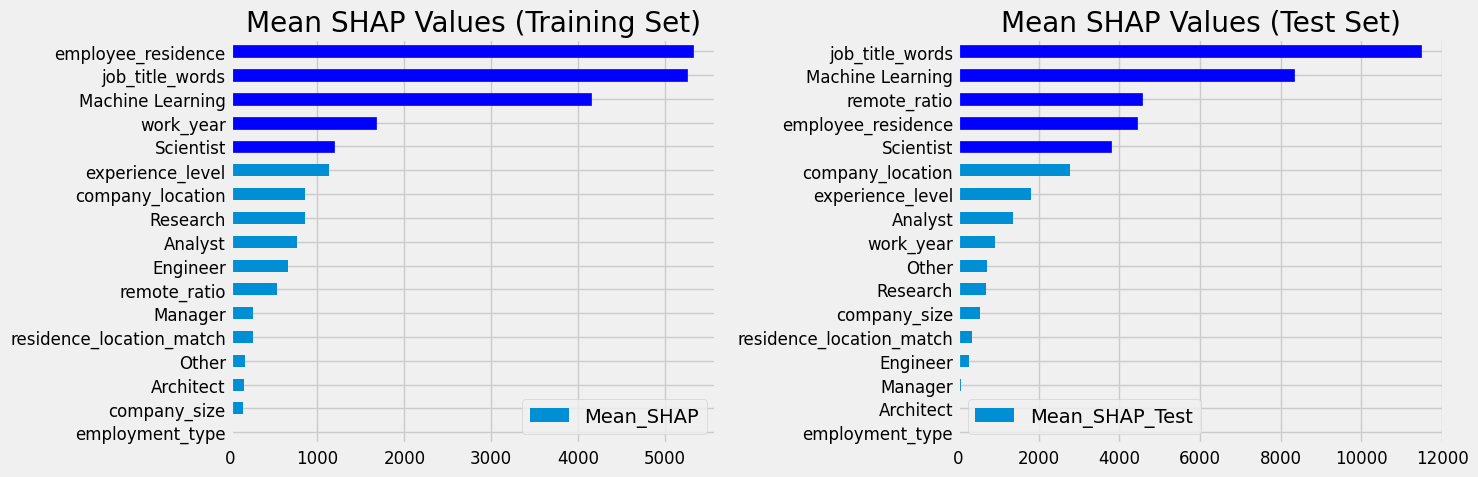

In [456]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(15, 5))

# Plot the mean SHAP values for the training set
shap_results_sorted_train = shap_results.sort_values(by='Mean_SHAP', ascending=True)
shap_results_sorted_train.plot(kind='barh', ax=axs[0])
axs[0].set_title('Mean SHAP Values (Training Set)')

# Highlight the top 5 features in green
top_5_train = shap_results_sorted_train.nlargest(5, 'Mean_SHAP').index
for feature in top_5_train:
    idx = shap_results_sorted_train.index.get_loc(feature)
    axs[0].get_children()[idx].set_color('blue')

# Plot the mean SHAP values for the test set
shap_results_sorted_test = shap_results_test.sort_values(by='Mean_SHAP_Test', ascending=True)
shap_results_sorted_test.plot(kind='barh', ax=axs[1])
axs[1].set_title('Mean SHAP Values (Test Set)')

# Highlight the top 5 features in green
top_5_test = shap_results_sorted_test.nlargest(5, 'Mean_SHAP_Test').index
for feature in top_5_test:
    idx = shap_results_sorted_test.index.get_loc(feature)
    axs[1].get_children()[idx].set_color('blue')

# Adjust layout
plt.tight_layout()

# Show the plots
plt.show()


The Mean SHAP value is calculated for each feature. The magnitude of the SHAP values shows how strong the feature is in predicting the output. In this dataset, there is a high imbalance for observation location, hence the SHAP are all positive. Nevertheless, both the train set and the test set agree that the most important contributors to the model are "employee_residence", "job_tite_words", "Machine Learning", and "Scientist". 

In summary:
* People having "Scientist" in the job title increases salary by $37k on average
* People having "Analyst" in their job title decreases salary by $2.4k
* The optimal model for forecasting scientist salaries as the treatment variable is Learner X employing Linear Regression.
* The most important features to reach to the model's conclusion are Job title word count and whether a person has Machine Learning in their job title
* SHAP values are positive for all features, showing that they all contribute positively to the predictions, with employee residence, job title words, Machine Learning, and Scientist being top prediction contributors
* For enhanced results, having a more balanced dataset with similar number of people from different countries and job types will reduce model bias and variance

More exploration can be done controlling confounders and stratifying the dataset in groups. I started exploring CATE below; this notebook is still to be continued! 👩🏻‍🔬🤗

In [428]:
# Plot shap dependence
"""learner_xLR.plot_shap_dependence(treatment_group='Scientist', 
                                 feature_idx=1,
                                 X=X_train, 
                                 tau=learner_xLR_tau, 
                                 interaction_idx = 'auto',
                                 features=X_train.columns)"""
                                 
# Plot SHAP values for each feature
# learner_xLR.plot_shap_values(X=X_train, tau=learner_xLR_tau, features=X_train.columns, shap_dict=shap_xlearner)

In [549]:
# Clear memory
import gc
gc.collect()

0

<font color='green'><p style='text-align:center;'> [End here for assignment and grading purposes]</p>



# CATE and ITE

In this section I am exloring  Conditional Average Treatment Effect, by stratifying observations into the following groups:
* 2 sets by territory (US and non-US)
* 3 sets ordered by company size (small, medium, and big)
* 4 sets ordered by experience level (Entry, Mid, Senior, Experienced)


In [485]:
# Isolate US and non-US salaries
us_salaries = salaries[salaries['employee_residence'] > 3000]
X_us = us_salaries.drop(columns = ["salary_in_usd"], axis=1)
y_us = us_salaries["salary_in_usd"]

non_us_salaries = salaries[salaries['employee_residence'] <= 3000]
X_non_us = non_us_salaries.drop(columns = ["salary_in_usd"], axis=1)
y_non_us = non_us_salaries["salary_in_usd"]

# Isolate company size
# company_size are ['S', 'M', 'L']
small_companies = salaries[salaries['company_size'] == 0]
X_small = small_companies.drop(columns = ["salary_in_usd"], axis=1)
y_small = small_companies["salary_in_usd"]

mid_companies = salaries[salaries['company_size'] == 1]
X_mid = mid_companies.drop(columns = ["salary_in_usd"], axis=1)
y_mid = mid_companies["salary_in_usd"]

big_companies = salaries[salaries['company_size'] == 2]
X_big = big_companies.drop(columns = ["salary_in_usd"], axis=1)
y_big = big_companies["salary_in_usd"]

# Isolate experience level
# experience_levels are ['EN', 'MI', 'SE', 'EX']
entry_salaries = salaries[salaries['experience_level'] == 0]
X_en = salaries[salaries['experience_level'] == 0].drop(columns = ["salary_in_usd"], axis=1)
y_en = salaries[salaries['experience_level'] == 0]["salary_in_usd"]

mid_salaries = salaries[salaries['experience_level'] == 1]
X_mi = salaries[salaries['experience_level'] == 1].drop(columns = ["salary_in_usd"], axis=1)
y_mi = salaries[salaries['experience_level'] == 1]["salary_in_usd"]

senior_salaries = salaries[salaries['experience_level'] == 2]
X_se = salaries[salaries['experience_level'] == 2].drop(columns = ["salary_in_usd"], axis=1)
y_se = salaries[salaries['experience_level'] == 2]["salary_in_usd"]

ex_salaries = salaries[salaries['experience_level'] == 3]
X_ex = salaries[salaries['experience_level'] == 3].drop(columns = ["salary_in_usd"], axis=1)
y_ex = salaries[salaries['experience_level'] == 3]["salary_in_usd"]



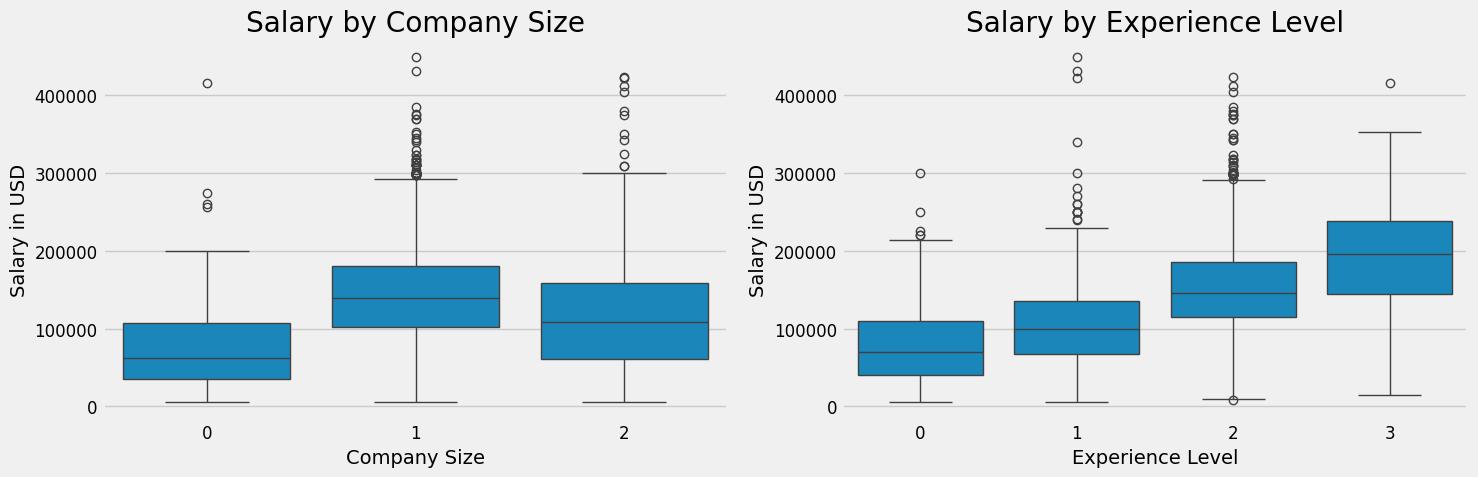

In [433]:
# plot company size and salary
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Plot company size and salary
sns.boxplot(x='company_size', y='salary_in_usd', data=salaries, ax=axes[0])
axes[0].set_title('Salary by Company Size')
axes[0].set_xlabel('Company Size')
axes[0].set_ylabel('Salary in USD')

# Plot experience level and salary
sns.boxplot(x='experience_level', y='salary_in_usd', data=salaries, ax=axes[1])
axes[1].set_title('Salary by Experience Level')
axes[1].set_xlabel('Experience Level')
axes[1].set_ylabel('Salary in USD')

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plot
plt.show()

Ther is a possibility that the company size and the experience level are causing salaries to be higher or lower. I am going to control these variables by applying the same treatment to the stratified groups.

In [476]:
# Does being in the US impact Engineers' salary on average?
# train test split for us_salaries
X_train_us, X_test_us, y_train_us, y_test_us = train_test_split(X_us, y_us, test_size=0.2, random_state=42)

n_train = len(X_train_us)
n_test = len(X_test_us)
train_index = np.arange(n_train)
test_index = np.arange(n_train, n_train + n_test)

# Reindex train and test sets
X_train_us.index = train_index
y_train_us.index = train_index
X_test_us.index = test_index
y_test_us.index = test_index

# Define the treatment variable based on the training data indices
treatment = us_salaries['Engineer'].iloc[train_index] == 1

# Calling the Base Learner class and feeding in XGB
learner_xXGB = BaseXRegressor(learner=XGBRegressor())
te, lb, ub = learner_xXGB.estimate_ate(X_train_us, treatment, y_train_us)
print('\nCATE of US Engineers:')
print_ate(te, lb, ub)

# Compare with non-US Engineers

# Train-test split for non-US salaries data with 80% train and 20% test
X_train_non_us, X_test_non_us, y_train_non_us, y_test_non_us = train_test_split(X_non_us, y_non_us, test_size=0.2, random_state=42)

# Create new indices for train and test sets
n_train = len(X_train_non_us)
n_test = len(X_test_non_us)
train_index = np.arange(n_train)
test_index = np.arange(n_train, n_train + n_test)

# Reindex train and test sets
X_train_non_us.index = train_index
y_train_non_us.index = train_index
X_test_non_us.index = test_index
y_test_non_us.index = test_index

# Define the treatment variable based on the training data indices
treatment = non_us_salaries['Engineer'].iloc[train_index] == 1

# Calling the Base Learner class and feeding in XGB
te, lb, ub = learner_xXGB.estimate_ate(X_train_non_us, treatment, y_train_non_us)
print('\nCATE of Non-US Engineers:')
print_ate(te, lb, ub)





CATE of US Engineers:
ATE estimate: $-2317.24
ATE lower bound: $-5945.68
ATE upper bound: $1311.19

CATE of Non-US Engineers:
ATE estimate: $-2750.84
ATE lower bound: $-7201.75
ATE upper bound: $1700.08


Being in the US or not does not impact the salary of those having "Engineer" in their title or not. Compared to non-engineers, engineers tend to earn $2,317 lower in salary no matter if they are in the US or not. 

In [478]:
entry_salaries['Analyst'].value_counts()

0    239
1     81
Name: Analyst, dtype: int64

In [490]:
# Does experience level impact Analysts' salary on average?
treatment = entry_salaries['Analyst'] == 1
te, lb, ub = learner_xXGB.estimate_ate(X_en, treatment, y_en)
print('\nCATE of Entry Analysts:')
print_ate(te, lb, ub)

treatment = mid_salaries['Analyst'] == 1
te, lb, ub = learner_xXGB.estimate_ate(X_mi, treatment, y_mi)
print('\nCATE of Mid Analysts:')
print_ate(te, lb, ub)

"""treatment = senior_salaries['Analyst'] == 1
te, lb, ub = learner_xXGB.estimate_ate(X_se, treatment, y_se)
print('\nCATE of Senior Analysts:')
print_ate(p, lb, ub)"""


treatment = ex_salaries['Analyst'] == 1
te, lb, ub = learner_xXGB.estimate_ate(X_ex, treatment, y_ex)
print('\nCATE of Experienced Analysts:')
print_ate(te, lb, ub)



CATE of Entry Analysts:
ATE estimate: $-28645.70
ATE lower bound: $-34157.02
ATE upper bound: $-23134.38

CATE of Mid Analysts:
ATE estimate: $-19999.05
ATE lower bound: $-25938.81
ATE upper bound: $-14059.29

CATE of Experienced Analysts:
ATE estimate: $-18102.15
ATE lower bound: $-30521.07
ATE upper bound: $-5683.24


Regardless of company size, employees having "Analyst" in their job title causes their salary to be lower on average compared to those who are not analysts.

In [487]:
# Distributions are highly imbalanced
senior_salaries['Analyst'].value_counts()
ex_salaries['Analyst'].value_counts()
mid_salaries['Analyst'].value_counts()

0    2114
1     402
Name: Analyst, dtype: int64

0    110
1      4
Name: Analyst, dtype: int64

0    608
1    197
Name: Analyst, dtype: int64

To be continued...